In [ ]:
# celldata too small so the consensus peaks are few

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
# import pysam
# from data_utils import *
from re import search

In [3]:
exec(open('/bi/home/lij/code/MTR_diff_endo/utils.py').read())
exec(open('/bi/home/lij/code/MTR_diff_endo/settings.py').read())


/bi/home/lij/env/miniconda3/envs/multiome_rna/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/bi/home/lij/env/miniconda3/envs/multiome_rna/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/bi/home/lij/env/miniconda3/envs/multiome_rna/lib/

## Set-up environment and download data 
We will first create a directory to store the data and results

## 0. Setting up the analysis directories & common variables

The following variables are used to define the default directories to store/load data from the current notebook (any of them can be modified in the individual steps).

* **Project directory:** used as default as root directory for the notebook. In this tutorial it also contains the *input data* (e.g. fragments files, annotations...). In case the different types of files are in distinct locations, replace them individually in the required steps. 

In [8]:
p = argparse.ArgumentParser( description='' )
p.add_argument( '--histone',               type=str,                       help='histone' )
# p.add_argument ('--slurm_array_id', type=int)
args = p.parse_args()
histone = args.histone

usage: ipykernel_launcher.py [-h] [--histone HISTONE]
ipykernel_launcher.py: error: unrecognized arguments: -f /bi/home/lij/.local/share/jupyter/runtime/kernel-607326eb-e68f-4f9f-bc0a-a3877b4b3162.json


SystemExit: 2

In [4]:
histone = 'H3K27ac'

In [5]:
baseDir = io["basedir"]+'/processed/dna/cistopic/'

In [6]:
# Project directory
projDir = baseDir + histone + '/'

* **Output directory:** to save the *results* from the analyses:

In [7]:
# Output directory
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)

* **TMP directory:** to store *temporary* files: 

In [8]:
# Temp dir
tmpDir = '/bi/home/lij/data/tmp'

In [9]:
import warnings
warnings.simplefilter(action='ignore')
import pandas
import pycisTopic
pycisTopic.__version__

'1.0a0'

Raw data used in this tutorial is available in GEO (GSE210749).

Processed loom files are available at: https://scope.aertslab.org/#/scenic-v2

A UCSC session is available at: https://genome-euro.ucsc.edu/s/cbravo/SCENIC%2B_Cortex

* **Project directory:** used as default as root directory for the notebook. In this tutorial it also contains the *input data* (e.g. fragments files, annotations...). In case the different types of files are in distinct locations, replace them individually in the required steps. 

* **Output directory:** to save the *results* from the analyses:

* **TMP directory:** to store *temporary* files: 

* **Others:** Most of the input parameters for the following sections are explained and defined in each step. 
These are some of the recurrent ones that you might want to set globally to avoid copy/pasing several times. For example, the input *fragments file* corresponding to each sample. It should be stored as a dictionary (the *sample ids* used as *keys* should match the sample ids in the *annotation* data frame).

In [23]:
## Path to fragments files of samples
fragments_path = io['basedir'] + '/original/DNA/'
# Def.endo.D0.H3K4me1.fragments.tsv_sorted.bed.gz
fragments_dict = {'EPI': fragments_path+'EPI.'+ histone+ '.fragments.tsv_sorted.bed.gz',
                 'PE': fragments_path+'PE.'+ histone+ '.fragments.tsv_sorted.bed.gz',
                'TE': fragments_path+'TE.'+ histone+ '.fragments.tsv_sorted.bed.gz'}

Note that in this tutorial we will only run the steps necessary within the SCENIC+ workflow. For a detailed workflow of all pycisTopic features, check the human cerebellum tutorial.

## 1. Getting pseudobulk profiles from cell annotations 

In this tutorial we assume we are analyzing the scATAC-seq data from a ***multiome*** dataset, which allows to easily get the cell annotations from the scRNA-seq analysis. In case of ***independent scATAC-seq data***, the cell annotation can also be obtained from alternative methods, such as unnanotated/preliminary clustering analysis (using predefined regions, for example SCREEN for mouse and human). In the later case, you can skip this section and use bulk regions as input to the QC step.

The barcode ***metadata*** should be provided as a `pd.DataFrame`.

* The **index*** of the pandas dataframe should correspond to BARCODE (e.g. ATGTCTGATAGA-1, additional tags are possible using `___`; e.g. ATGTCTGATAGA-1___sample_1) **and** it must contain a **'sample_id'** column indicating the sample label fo origin. It is also possible to use other separation pattern (e.g. `-`), but then it will have to be specified in the function.

* Alternative: add a **column named 'barcode'** to the metadata with the corresponding cell barcodes (in this case the name of the cells will not be used to infer the barcode id). This is the option we use in this tutorial as well.

In this example, we will load the barcode metadata from the scRNA-seq analysis stored in a loom file. For each sample we have different sample_id names for the barcodes. In this case, we will simplify them a bit, and make sure they match with the keys in the fragments file.

In [24]:
# Adding cell information
cell_data =  pd.read_csv(baseDir+'celldata.tsv', sep='\t')

In [25]:
cell_data['sample_id'] = cell_data['celltype']

In [26]:
cell_data['barcode'] = cell_data.index.tolist()

In [27]:
cell_data

,orig.ident,nCount_RNA,nFeature_RNA,cellid,sample_bio.id,sub.lib,percent.mt,RNA_snn_res.0.1,seurat_clusters,celltype,sample_id,barcode
42:16:18:S1,S1,5706,1858,S1_42:16:18:02,E45_2,S1,0.017525,2,2,EPI,EPI,42:16:18:S1
19:11:03:S1,S1,17888,3630,S1_19:11:03:02,E45_2,S1,0.000000,2,2,EPI,EPI,19:11:03:S1
01:44:41:S2,S2,10662,2323,S2_01:44:41:02,E45_2,S2,0.028137,2,2,EPI,EPI,01:44:41:S2
40:33:31:S4,S4,16413,3409,S4_40:33:31:02,E45_2,S4,0.000000,2,2,EPI,EPI,40:33:31:S4
36:22:33:S1,S1,21487,3660,S1_36:22:33:01,E45_1,S1,0.000000,2,2,EPI,EPI,36:22:33:S1
...,...,...,...,...,...,...,...,...,...,...,...,...
41:20:22:S1,S1,3777,1228,S1_41:20:22:02,E45_2,S1,0.000000,0,0,TE,TE,41:20:22:S1
27:20:22:S4,S4,3864,1213,S4_27:20:22:01,E45_1,S4,0.000000,0,0,TE,TE,27:20:22:S4
08:30:22:S4,S4,4096,1084,S4_08:30:22:01,E45_1,S4,0.000000,0,0,TE,TE,08:30:22:S4
42:14:43:S2,S2,3826,1068,S2_42:14:43:01,E45_1,S2,0.000000,0,0,TE,TE,42:14:43:S2


In order to produce the bigwig files, we also need to know the overall ***size of the chromosomes***. We can easily download this information from the UCSC.

In [16]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('_random', '') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x]+'.1' if 'chr' not in chromsizes['Chromosome'][x] else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

Now we have all the ingredients we need  to generate the pseudobulk files. With this function we will generate fragments files per group and the corresponding bigwigs. The mandatory input to this function are:
* The annotation dataframe (`input_data`)
* The `variable` used to group the cells
* The chromosome sizes
* The paths to where the bed and bigiwg files will be written
* A dictionary indicating the fragments file corresponsing to each sample. **The sample ids used as keys in this dictionary must match with the sample ids in the annotation data frame!**

The output will be two dictionaries containing the paths to the bed and bigwig files, respectively, to each group.

In [22]:
fragments_dict

{'EPI': '/bi/home/lij/data/projects/scCUT_Tag_rna/E45/original/DNA/EPI.H3K27ac.fragments.tsv_sorted.bed.gz',
 'PE': '/bi/home/lij/data/projects/scCUT_Tag_rna/E45/original/DNA/PE.H3K27ac.fragments.tsv_sorted.bed.gz',
 'TE': '/bi/home/lij/data/projects/scCUT_Tag_rna/E45/original/DNA/TE.H3K27ac.fragments.tsv_sorted.bed.gz'}

In [28]:
# os.mkdir(outDir + 'consensus_peak_calling')
# os.mkdir(outDir + 'consensus_peak_calling/pseudobulk_bed_files/')
# os.mkdir(outDir + 'consensus_peak_calling/pseudobulk_bw_files/')
from pycisTopic.pseudobulk_peak_calling import *
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'sample_id',
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = outDir + 'consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path = outDir + 'consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 5,
                 normalize_bigwig = True,
#                  remove_duplicates = True,
#                  _temp_dir = tmpDir + 'ray_spill',
                 split_pattern = '___')

2024-07-29 11:38:18,317 cisTopic     INFO     Splitting fragments by cell type.
2024-07-29 11:38:21,456 cisTopic     INFO     generating bigwig files


In [29]:
# Save
import pickle 
with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)

import pickle 
with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

## 2. Inferring consensus peaks

In the following step, we will use MACS2 to call peaks in each group (in this case, cell type). The default parameters are those recommended for ATAC-seq data.

In [30]:
# Load cisTopic object
import pickle
infile = open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'rb')
bed_paths = pickle.load(infile)
infile.close()

In [32]:
import os
from pycisTopic.pseudobulk_peak_calling import *
macs_path='/bi/home/lij/env/miniconda3/envs/R/bin/macs2'
macs_outdir = outDir + 'consensus_peak_calling/MACS/'
# os.mkdir(macs_outdir)
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 macs_outdir,
                                 genome_size='mm',
                                 n_cpu=5,
                                 input_format='BEDPE',
                                 shift=73, 
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.2,
                                 _temp_dir = tmpDir + 'ray_spill')

2024-07-29 12:43:16,733	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(pid=1987863) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(macs_call_peak_ray pid=1987863) 2024-07-29 12:43:30,702 cisTopic     INFO     Calling peaks for PE with /bi/home/lij/env/miniconda3/envs/R/bin/macs2 callpeak --treatment /bi/home/lij/data/projects/scCUT_Tag_rna/E45/processed/dna/cistopic/H3K27ac/output/consensus_peak_calling/pseudobulk_bed_files/PE.fragments.tsv.gz --name PE  --outdir /bi/home/lij/data/projects/scCUT_Tag_rna/E45/processed/dna/cistopic/H3K27ac/output/consensus_peak_calling/MACS/ --format BEDPE --gsize mm --qvalue 0.2 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=1987867) 2024-07-29 12:43:30,709 cisTopic     INFO     Calling peaks for TE with /bi/home/lij/env/miniconda3/envs/R/bin/macs2 callpeak --treatment /bi/home/lij/data/projects/scCUT_Tag_rna/E45/processed/dna/cistopic/H3K27ac/output/consensus_peak_calling/pseudobulk_bed_files/TE.fragments.tsv.gz --name TE  --outdir /bi/home/lij/data/projects/scCUT_Tag_rna/E45/processed/dna/cistopic/H3K27ac/output/consensus_peak

(pid=1987866) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


In [33]:
# Save
import pickle 
with open(outDir + 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl', 'wb') as f:
  pickle.dump(narrow_peaks_dict, f)

Finally, it is time to derive the consensus peaks. To do so, we use the TGCA iterative peak filtering approach. First, each summit is extended a `peak_half_width` in each direction and then we iteratively filter out less significant peaks that overlap with a more significant one. During this procedure peaks will be merged and depending on the number of peaks included into them, different processes will happen:

* **1 peak**:  The original peak region will be kept
* **2 peaks**:  The original peak region with the highest score will be kept
* **3 or more peaks**:  The orignal peak region with the most significant score will be taken, and all the original peak regions in this merged peak region that overlap with the significant peak region will be removed. The process is repeated with the next most significant peak (if it was not removed already) until all peaks are processed.

This proccess will happen twice, first in each pseudobulk peaks; and after peak score normalization, to process all peaks together.

In [34]:
# Get chromosome sizes (for hg38 here). We need them to ensure that extending the summits we don't fall out of the chromosome.
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [35]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width=200
# path_to_blacklist='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes) 

2024-07-29 12:44:27,686 cisTopic     INFO     Extending and merging peaks per class
2024-07-29 12:45:03,217 cisTopic     INFO     Normalizing peak scores
2024-07-29 12:45:03,306 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2024-07-29 12:45:10,602 cisTopic     INFO     Done!


In [36]:
consensus_peaks

,Chromosome,Start,End,Name,Score
0,chr1,3046643,3047043,TE_peak_1,15.127640
1,chr1,3054285,3054685,TE_peak_2,6.541682
2,chr1,3058237,3058637,TE_peak_3,31.072991
3,chr1,3106288,3106688,EPI_peak_1,43.124515
4,chr1,3221642,3222042,TE_peak_4,2.861986
...,...,...,...,...,...
121474,chrY,89829175,89829575,TE_peak_102322,2.861986
121475,chrY,90739773,90740173,TE_peak_102323,10.630234
121476,chrY,90802591,90802991,TE_peak_102324,6.541682
121477,chrY,90804653,90805053,TE_peak_102325,10.630234


In [37]:
# Write to bed
consensus_peaks.to_bed(path= outDir + 'consensus_peak_calling/consensus_regions.bed', keep=True, compression='infer', chain=False)

The next step is to perform QC in the scATAC-seq samples (in this case, only one run). There are several measurements and visualizations performed in this step:

* Barcode rank plot
* Duplication rate
* Insertion size
* TSS enrichment
* Fraction of Reads In Peaks (FRIP)

To calculate the TSS enrichment we need to provide TSS annotations. You can easily download them via pybiomart.

In [38]:
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (hg38)
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
# dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

If you want to run all (or several of) the metrics, you can use the `compute_qc_stats()` function. As input you need to provide a dictionary containing the fragments files per sample and another dictionary the corresponding regions to use to estimate the FRIP. 

In [39]:
from pycisTopic.qc import *
## Set regions. We will use the consensus peaks we have just called, but we could also use the bulk peaks per sample instead for this step
path_to_regions= {'PE': outDir + 'consensus_peak_calling/consensus_regions.bed',
                 'TE': outDir + 'consensus_peak_calling/consensus_regions.bed',
                 'EPI': outDir + 'consensus_peak_calling/consensus_regions.bed'}
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 5,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

2024-07-29 12:45:12,555 cisTopic     INFO     n_cpu is larger than the number of samples. Setting n_cpu to the number of samples


2024-07-29 12:45:16,478	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(pid=1989435) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(compute_qc_stats_ray pid=1989435) 2024-07-29 12:45:20,902 cisTopic     INFO     Reading TE
(compute_qc_stats_ray pid=1989434) 2024-07-29 12:45:20,901 cisTopic     INFO     Reading EPI
(compute_qc_stats_ray pid=1989433) 2024-07-29 12:45:20,902 cisTopic     INFO     Reading PE
(compute_qc_stats_ray pid=1989434) 2024-07-29 12:45:21,934 cisTopic     INFO     Computing barcode rank plot for EPI
(compute_qc_stats_ray pid=1989434) 2024-07-29 12:45:21,935 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=1989434) 2024-07-29 12:45:21,951 cisTopic     INFO     Marking barcodes with more than 100
(compute_qc_stats_ray pid=1989434) 2024-07-29 12:45:21,951 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=1989434) 2024-07-29 12:45:21,952 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=1989433) 2024-07-29 12:45:21,951 cisTopic     INFO     Computing barcode rank plot for PE
(compute_qc_stats_ray pid=1989434) 2024-07-29 12:45:22,038 cisTopi

(pid=1989434) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject [repeated 2x across cluster]


In [41]:
# os.makedirs(outDir+'quality_control')
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

import pickle 
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

### 3a. Sample-level statistics

Once the QC metrics have been computed you can visualize the results at the sample-level and the barcode-level. Sample-level statistics can be used to assess the overall quality of the sample, while barcode level statistics can be use to differentiate good quality cells versus the rest. The sample-level graphs include:

* **Barcode rank plot**: The barcode rank plot shows the distribution of non-duplicate reads and which barcodes were inferred to be associated with cells. A steep drop-off ('knee') is indicative of good separation between the cell-associated barcodes and the barcodes associated with empty partitions.

* **Insertion size**: ATAC-seq requires a proper pair of Tn5 transposase cutting events at the ends of DNA. In the nucleosome-free open chromatin regions, many molecules of Tn5 can kick in and chop the DNA into small pieces; around nucleosome-occupied regions, and Tn5 can only access the linker regions. Therefore, in a good ATAC-seq library, you should expect to see a sharp peak at the <100 bp region (open chromatin), and a peak at ~200bp region (mono-nucleosome), and other larger peaks (multi-nucleosomes). A clear nucleosome pattern indicates a good quality of the experiment.

* **Sample TSS enrichment**: The TSS enrichment calculation is a signal to noise calculation. The reads around a reference set of TSSs are collected to form an aggregate distribution of reads centered on the TSSs and extending to 1000 bp in either direction (for a total of 2000bp). This distribution is then normalized by taking the average read depth in the 100 bps at each of the end flanks of the distribution (for a total of 200bp of averaged data) and calculating a fold change at each position over that average read depth. This means that the flanks should start at 1, and if there is high read signal at transcription start sites (highly open regions of the genome) there should be an increase in signal up to a peak in the middle.

* **FRIP distribution**: Fraction of all mapped reads that fall into the called peak regions, i.e. usable reads in significantly enriched peaks divided by all usable reads. A low FRIP indicates that many reads form part of the background, and so that the data is noisy.

* **Duplication rate**: A fragment is considered “usable” if it uniquely maps to the genome and remains after removing PCR duplicates (defined as two fragments that map to the same genomic position and have the same unique molecular identifier). The duplication rate serves to estimate the amount of usable reads per barcode. High duplication rates may indicate over-sequencing or lack of fragments after transposition and encapsulation. We recommend using `duplicate_rate_as_hexbin = True` when working with big fragments files.

In [42]:
# Load sample metrics
import pickle
infile = open(outDir + 'quality_control/profile_data_dict.pkl', 'rb')
profile_data_dict = pickle.load(infile)
infile.close()

2024-07-29 12:45:56,851 cisTopic     INFO     All fragments are unique
2024-07-29 12:45:56,942 cisTopic     INFO     All fragments are unique
2024-07-29 12:45:56,980 cisTopic     INFO     All fragments are unique


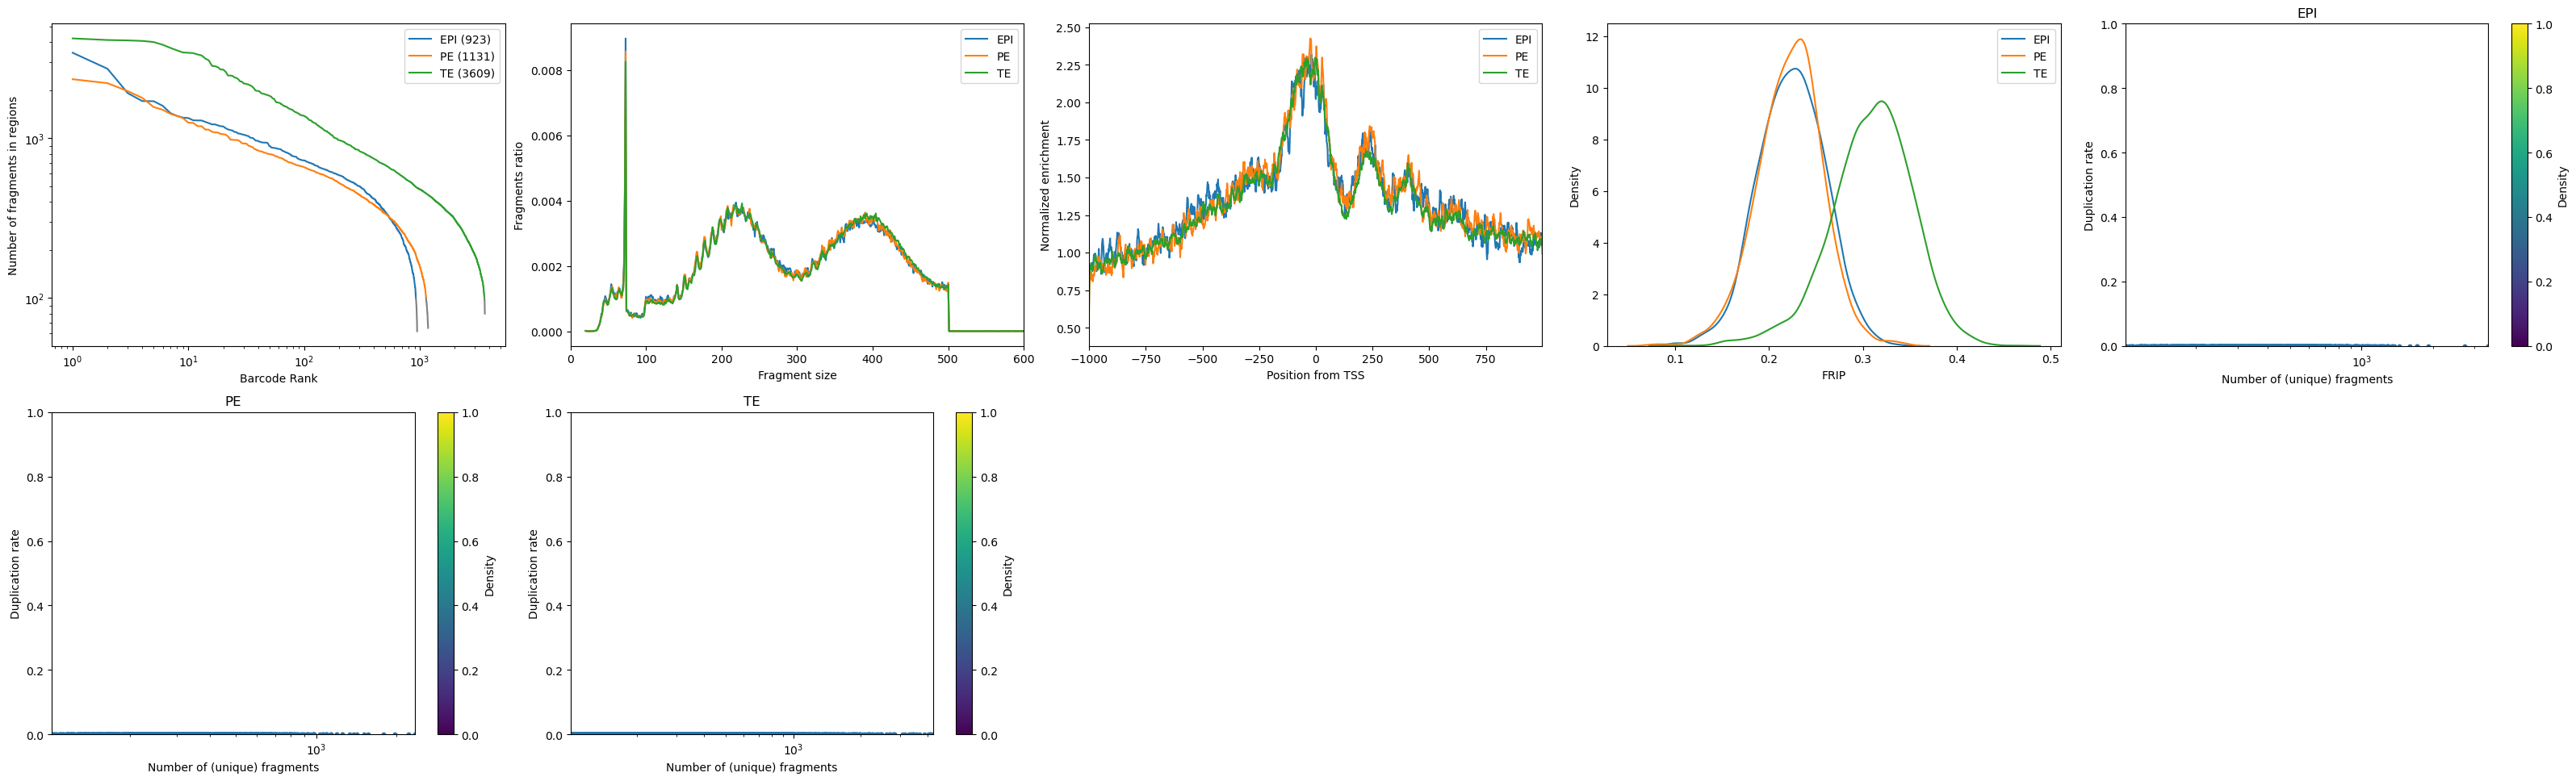

In [43]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distribution_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf',
           duplicate_rate_as_hexbin = False)

### 3b. Barcode level statistics

Barcode-level statistics can be used to select high quality cells. Typical measurements that can be used are:

* **Total number of (unique) fragments**
* **TSS enrichment**: The score at position in the TSS enrichmen score for for each barcode (at position 0, the TSS). Noisy cells will have a low TSS enrichment.
* **FRIP**: The fraction of reads in peaks for each barcode. Noisy cells have low FRIP values. However, this filter should be used with nuance, as it depends on the quality of the original peaks. For example, if there is a rare population in the sample, its specific peaks may be missed by peak calling algorithms, causing a decrease in their FRIP values.

In [44]:
# Load barcode metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()

In [45]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig = {}
FRIP_NR_FRAG_filter = {}
TSS_NR_FRAG_fig = {}
TSS_NR_FRAG_filter = {}
DR_NR_FRAG_fig = {}
for sample in metadata_bc.keys():
    FRIP_NR_FRAG_fig[sample], FRIP_NR_FRAG_filter[sample]=plot_barcode_metrics(metadata_bc[sample],
                                           var_x='Log_unique_nr_frag',
                                           var_y='FRIP',
                                           min_x=3,
                                           max_x=None,
                                           min_y=0.4,
                                           max_y=None,
                                           return_cells=True,
                                           return_fig=True,
                                           plot=False,
                                           save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG_'+sample+'.pdf')
    # Return figure to plot together with other metrics, and cells passing filters
    TSS_NR_FRAG_fig[sample], TSS_NR_FRAG_filter[sample]=plot_barcode_metrics(metadata_bc[sample],
                                          var_x='Log_unique_nr_frag',
                                          var_y='TSS_enrichment',
                                          min_x=3,
                                          max_x=None,
                                          min_y=4,
                                          max_y=None,
                                          return_cells=True,
                                          return_fig=True,
                                          plot=False,
                                          save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG_'+sample+'.pdf')
    # Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
    DR_NR_FRAG_fig[sample]=plot_barcode_metrics(metadata_bc[sample],
                                          var_x='Log_unique_nr_frag',
                                          var_y='Dupl_rate',
                                          min_x=3,
                                          max_x=None,
                                          min_y=None,
                                          max_y=None,
                                          return_cells=False,
                                          return_fig=True,
                                          plot=False,
                                          plot_as_hexbin = True)

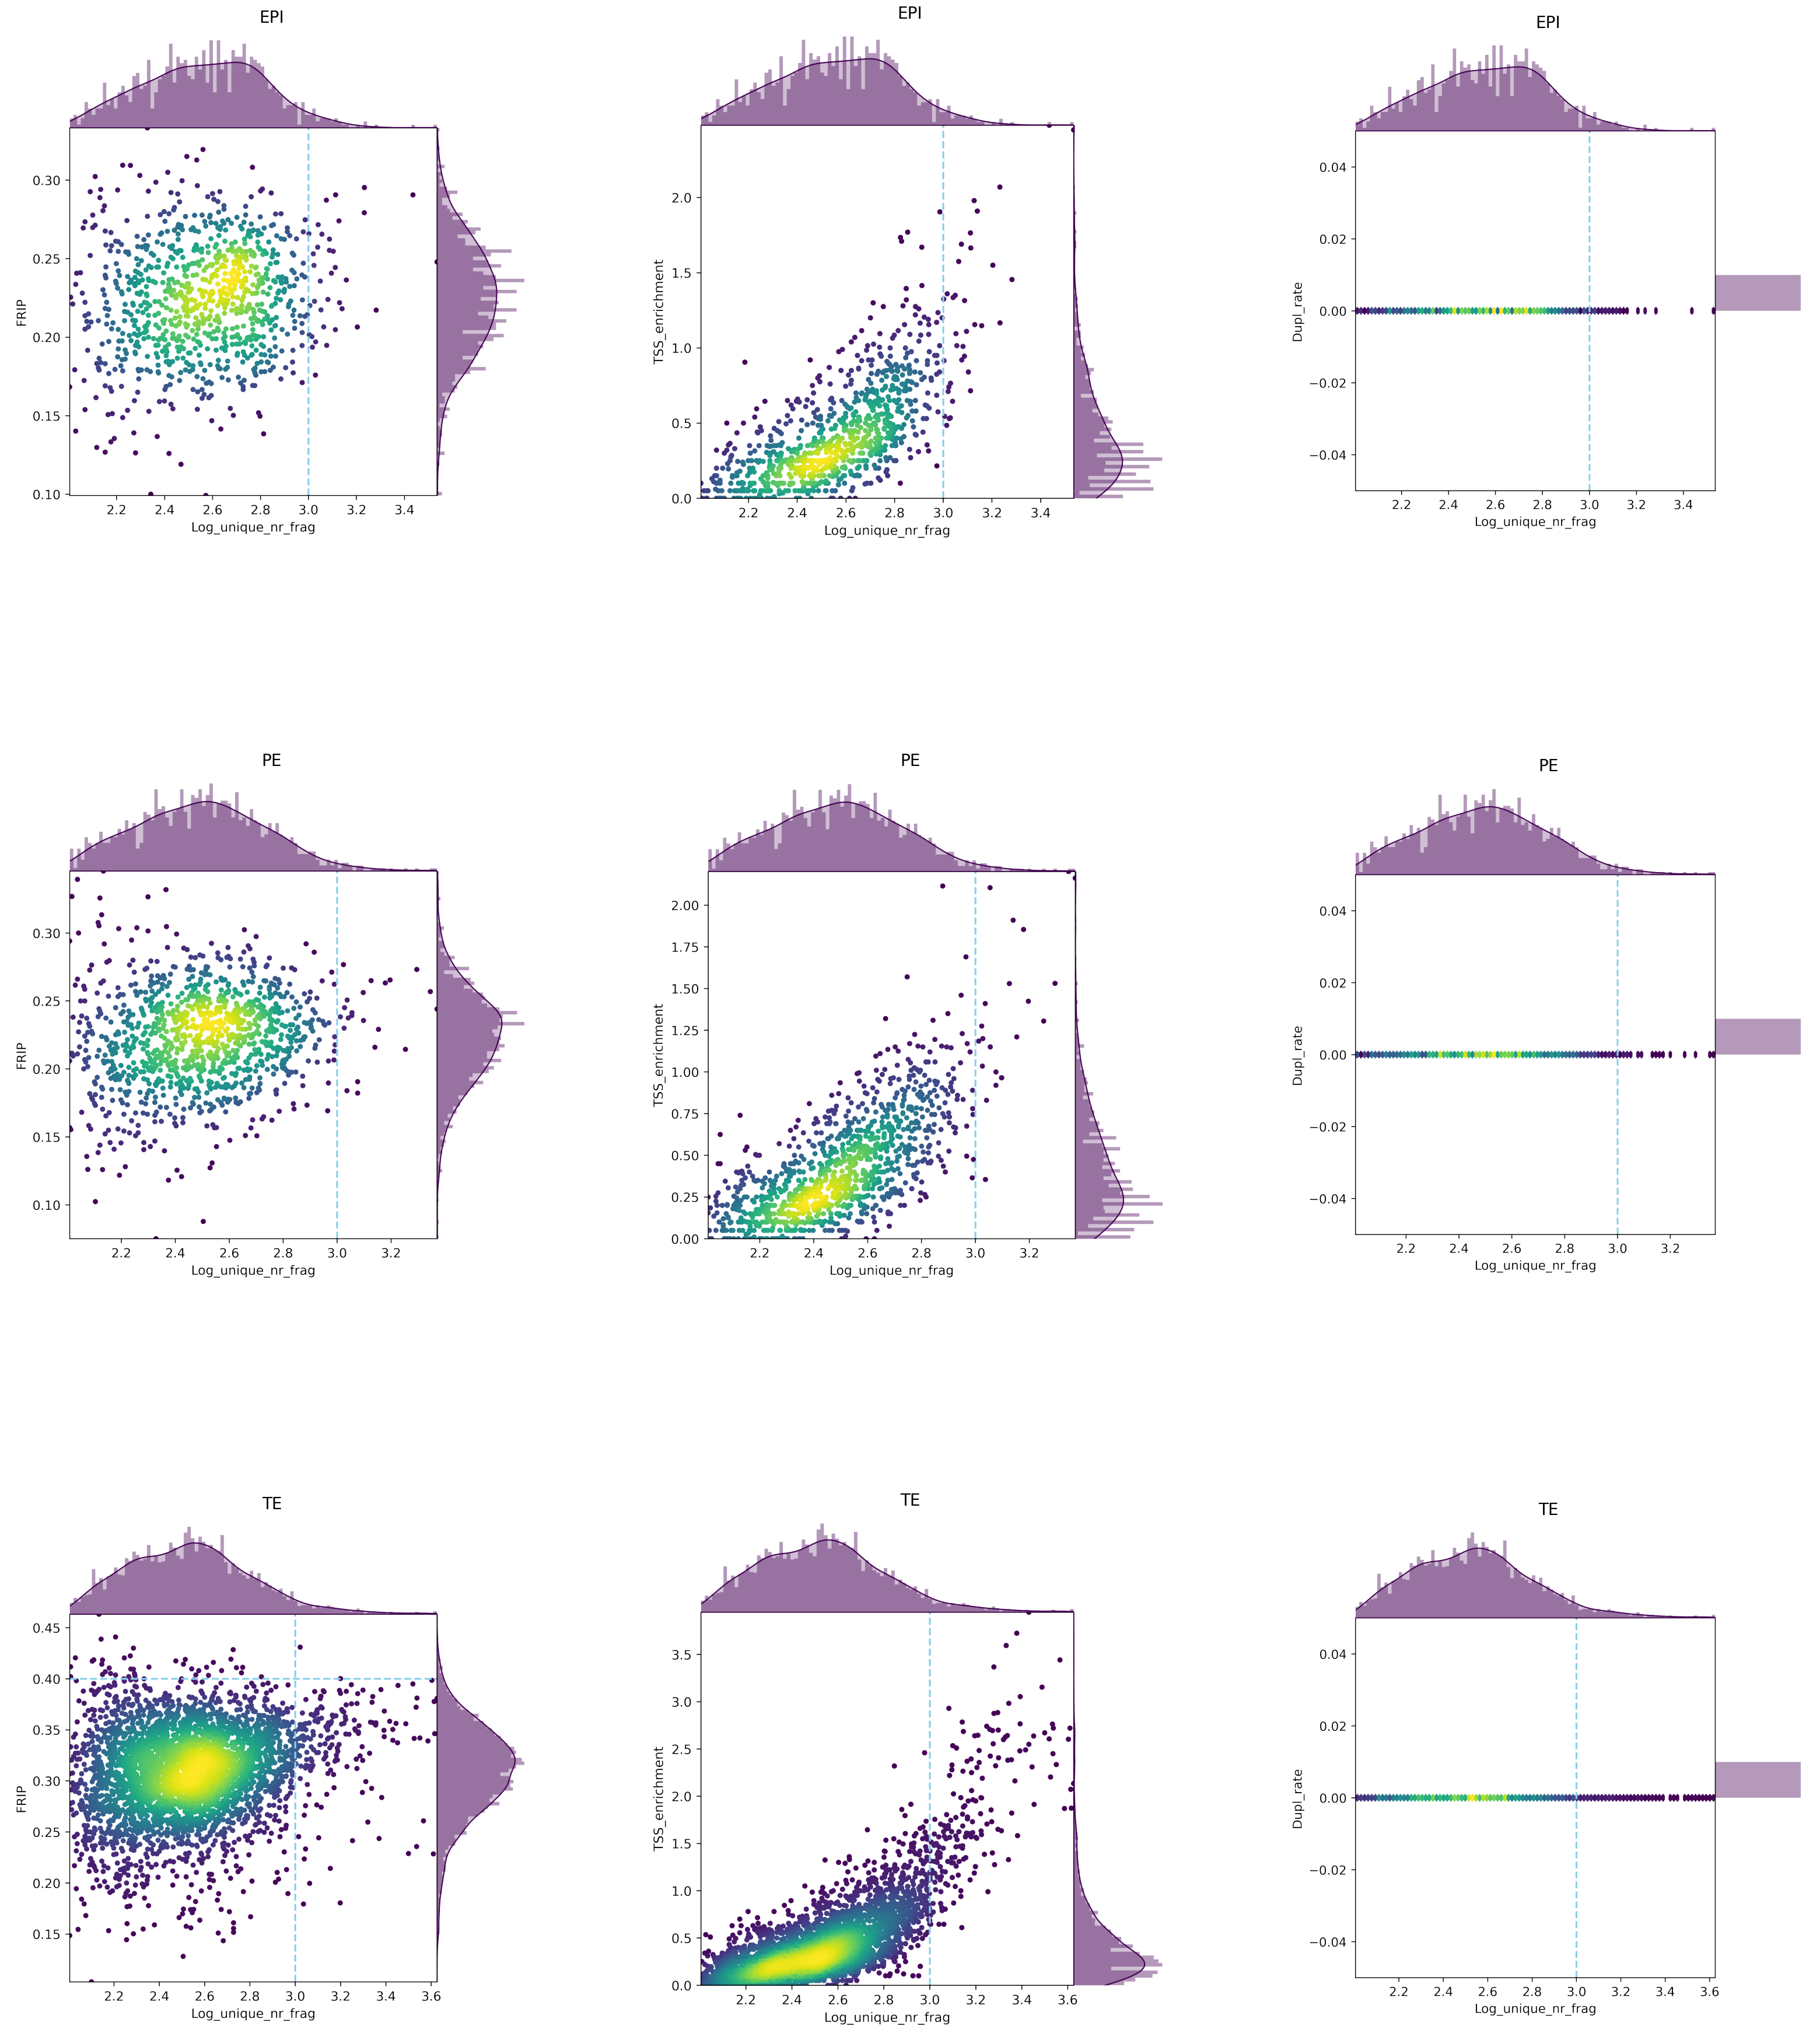

In [46]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40, 80))
i=1
for sample in FRIP_NR_FRAG_fig.keys():
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(FRIP_NR_FRAG_fig[sample]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(TSS_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    plt.gca().set_title(sample, fontsize=20)
    i += 1
    img = fig2img(DR_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
plt.savefig(outDir + 'quality_control/combined_qc.pdf')

In [47]:
# import pickle 
# with open(outDir +'/quality_control/bc_passing_filters.pkl', 'wb') as f:
#   pickle.dump(sel_cells_dict, f)

## 4. Create cisTopic object

In this step a fragments count matrix will be generated, in which the fragments in each region for each barcode is indicated. For multiple samples, you can add additional entries in `fragment_dict`, and a cisTopic object will be generated per sample. As regions, we will use the consensus peaks derived from the scRNA-seq annotations. This cisTopic object will contain:

* Path/s to fragment file/s (if generated from fragments files)
* Fragment count matrix and binary accessibility matrix
* Cell and region metadata

In [48]:
fragments_dict.keys()

dict_keys(['EPI', 'PE', 'TE'])

In [49]:
path_to_regions = outDir + 'consensus_peak_calling/consensus_regions.bed'

In [50]:
regions = pr.read_bed(path_to_regions)
regions = regions[["Chromosome", "Start", "End"]]
regions.regionID = (
        regions.Chromosome.astype(str)
        + ":"
        + regions.Start.astype(str)
        + "-"
        + regions.End.astype(str)
    ).to_list()

In [51]:
regions

,Chromosome,Start,End,regionID
0,chr1,3046643,3047043,chr1:3046643-3047043
1,chr1,3054285,3054685,chr1:3054285-3054685
2,chr1,3058237,3058637,chr1:3058237-3058637
3,chr1,3106288,3106688,chr1:3106288-3106688
4,chr1,3221642,3222042,chr1:3221642-3222042
...,...,...,...,...
121474,chrY,89829175,89829575,chrY:89829175-89829575
121475,chrY,90739773,90740173,chrY:90739773-90740173
121476,chrY,90802591,90802991,chrY:90802591-90802991
121477,chrY,90804653,90805053,chrY:90804653-90805053


In [52]:
# Path to regions
path_to_regions = outDir + 'consensus_peak_calling/consensus_regions.bed'
# Blacklist
# path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
# Valid barcodes
import pickle
# infile = open(outDir +'/quality_control/bc_passing_filters.pkl', 'rb')
# bc_passing_filters = pickle.load(infile)
# infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
#                                                path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
#                                                valid_bc=bc_passing_filters[key],
                                               n_cpu=5,
                                               project=key) for key in fragments_dict.keys()]

2024-07-29 12:46:27,138 cisTopic     INFO     Reading data for EPI
2024-07-29 12:46:28,556 cisTopic     INFO     metrics provided!
2024-07-29 12:46:28,590 cisTopic     INFO     Counting fragments in regions


2024-07-29 12:46:31,470	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-07-29 12:46:34,511 cisTopic     INFO     Creating fragment matrix
2024-07-29 12:46:34,889 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-07-29 12:46:35,091 cisTopic     INFO     Creating CistopicObject
2024-07-29 12:46:35,214 cisTopic     INFO     Done!
2024-07-29 12:46:35,227 cisTopic     INFO     Reading data for PE
2024-07-29 12:46:35,797 cisTopic     INFO     metrics provided!
2024-07-29 12:46:35,829 cisTopic     INFO     Counting fragments in regions


2024-07-29 12:46:38,501	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-07-29 12:46:41,392 cisTopic     INFO     Creating fragment matrix
2024-07-29 12:46:41,784 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-07-29 12:46:42,043 cisTopic     INFO     Creating CistopicObject
2024-07-29 12:46:42,175 cisTopic     INFO     Done!
2024-07-29 12:46:42,189 cisTopic     INFO     Reading data for TE
2024-07-29 12:46:43,374 cisTopic     INFO     metrics provided!
2024-07-29 12:46:43,450 cisTopic     INFO     Counting fragments in regions


2024-07-29 12:46:47,169	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-07-29 12:46:50,347 cisTopic     INFO     Creating fragment matrix
2024-07-29 12:46:58,496 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-07-29 12:47:00,449 cisTopic     INFO     Creating CistopicObject
2024-07-29 12:47:00,778 cisTopic     INFO     Done!


Since in this case we have multiple samples, we have to merge the list of cisTopic objects into a unique object.

In [53]:
cistopic_obj = merge(cistopic_obj_list)

2024-07-29 12:47:01,375 cisTopic     INFO     cisTopic object 1 merged
2024-07-29 12:47:02,508 cisTopic     INFO     cisTopic object 2 merged


In [54]:
# cistopic_obj.celltype = [x.split('___')[1] for x in cistopic_obj.cell_names]

In [55]:
# cell_data.index = cell_data.barcode + '___'+ cell_data.celltype

In [56]:
# cell_data.loc[cistopic_obj.cell_names,]

In [57]:
# cistopic_obj.add_cell_data(cell_data)

Optionally, you can run also scrublet on the fragment count matrix to infer doublets from the scATAC-seq. Note that if you have multiple samples, scrublet must be run per sample.

In [58]:
# cistopic_obj.subset(cells = cell_data.index.tolist())

In [59]:
# # Run scrublet
# import scrublet as scr
# import pandas as pd
# scrublet_pd_list=[]
# for sample_id in set(cistopic_obj.cell_data['sample_id']):
#     cistopic_obj_sample_id = cistopic_obj.subset(cells=cistopic_obj.cell_data[cistopic_obj.cell_data.sample_id== sample_id].index.to_list(),copy=True)
#     scrub = scr.Scrublet(cistopic_obj_sample_id.fragment_matrix.T, expected_doublet_rate=0.1)
#     doublet_scores, predicted_doublets = scrub.scrub_doublets()
#     scrub.call_doublets(threshold=0.4)
#     scrublet_pd_list.append(pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj_sample_id.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T)

We can know add scrublet results to the object. In this case, we will not filter out predicted doublets, but we will use the information a posteriori to confirm if we have doublet clusters.

In [60]:
# scrublet_pd = pd.concat(scrublet_pd_list)
# cistopic_obj.add_cell_data(scrublet_pd)

In [61]:
# Save
with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 5. Run models

The next step is to run the LDA models. There are two types of LDA models (with Collapsed Gibbs Sampling) you can run:

* **Serial LDA**: The parallelization is done between models rather than within each model. Recommended for small-medium sized data sets in which several models with different number os topics are being tested. You can run these models with `runCGSModels()`.
* **Parallel LDA with MALLET**: The parallelization is done within each model. Recommended for large data sets where a few models with different number of topics are being tested. If working in a cluster, we recommed to submit a job per model so they can run simultaneously. You can run it with `runCGSModelsMallet()`.

In this tutorial we will use Mallet.

In [62]:
# Load cisTopic object
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [63]:
# Load functions 
from pycisTopic.lda_models import *
# Run models
# ray.shutdown()
models=run_cgs_models(
                    cistopic_obj,
                    n_topics=[2,5, 6,7,8,9,10],
                    n_cpu=24,
                    n_iter=500, 
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
#                     tmp_path=tmpDir, #Use SCRATCH if many models or big data set
                    save_path=None)

2024-07-29 12:47:07,720	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(pid=1993249) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(run_cgs_model pid=1993249) 2024-07-29 12:47:11,806 cisTopic     INFO     Running model with 2 topics


(pid=1993247) <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject [repeated 6x across cluster]


(run_cgs_model pid=1993247) 2024-07-29 12:47:17,517 cisTopic     INFO     Running model with 10 topics [repeated 6x across cluster]
(run_cgs_model pid=1993249) 2024-07-29 12:47:33,253 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=1993255) 2024-07-29 12:47:44,956 cisTopic     INFO     Model with 5 topics done!
(run_cgs_model pid=1993256) 2024-07-29 12:47:49,296 cisTopic     INFO     Model with 6 topics done!
(run_cgs_model pid=1993251) 2024-07-29 12:47:59,043 cisTopic     INFO     Model with 8 topics done! [repeated 2x across cluster]
(run_cgs_model pid=1993247) 2024-07-29 12:48:05,853 cisTopic     INFO     Model with 10 topics done! [repeated 2x across cluster]


In [64]:
# Save
import pickle 
with open(outDir+'models.pkl', 'wb') as f:
  pickle.dump(models, f)

If you are working on a cluster and want to run several models, we recommend to submit this step as a job. You can use the `runModels_lda_mallet.py` script.

In [235]:
# %%bash
# #!/bin/bash -l
# ## Job will last 12 hours.
# #PBS -l walltime=12:00:00
# ## Job needs 1 nodes and 24 cores per node.
# #PBS -l nodes=1:ppn=24
# ## Job request memory
# #PBS -lmem=180gb # or 180gb
# ## Specify project credits name to use credits for running the job.
# #PBS -A lp_symbiosys
# ## Batch job name.
# #PBS -N 10x_multiomics_brain
# ## Email options.
# #PBS -m abe
# #PBS -M carmen.bravogonzalezblas@kuleuven.vib.be

# module load Python/3.7.4-foss-2018a
# cd /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic
# singularity exec -B /lustre1,/staging,/data,/vsc-hard-mounts,/scratch scenicplus.sif python pycisTopic/model_scripts/runModels_lda_mallet.py \
#         -i /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/tutorial/cisTopicObject.pkl \
#         -o /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/tutorial/models/mallet.pkl \
#         -nt 2,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100 \
#         -c 23 \
#         -it 500 \
#         -a 50 \
#         -abt True \
#         -e 0.1 \
#         -ebt False \
#         -sp /scratch/leuven/313/vsc31305/cortex_tutorial/mallet/intermediate_models \
#         -s 555 \
#         -td /scratch/leuven/313/vsc31305/cortex_tutorial/mallet/tmp

## 6. Model selection

There are several methods that can be used for model selection:

* **Minmo_2011**: Uses the average model coherence as calculated by Mimno et al (2011). In order to reduce the impact of the number of topics, we calculate the average coherence based on the top selected average values. The better the model, the higher coherence.
* **Log-likelihood**: Uses the log-likelihood in the last iteration as calculated by Griffiths and Steyvers (2004). The better the model, the higher the log-likelihood.
* **Arun_2010**: Uses a density-based metric as in Arun et al (2010) using the topic-region distribution, the cell-topic distribution and the cell coverage. The better the model, the lower the metric.
* **Cao_Juan_2009**: Uses a divergence-based metric as in Cao Juan et al (2009) using the topic-region distribution. The better the model, the lower the metric.

For scATAC-seq data models, the most helpful methods are Minmo (topic coherence) and the log-likelihood in the last iteration.

In [236]:
histone = 'H3K27ac'

In [65]:
baseDir = io["basedir"]+'/processed/dna/cistopic/'

In [66]:
# Project directory
projDir = baseDir + histone + '/'

* **Output directory:** to save the *results* from the analyses:

In [67]:
# Output directory
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [68]:
# Load cisTopic object
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load models
import pickle
infile = open(outDir + 'models.pkl', 'rb')
models = pickle.load(infile)
infile.close()

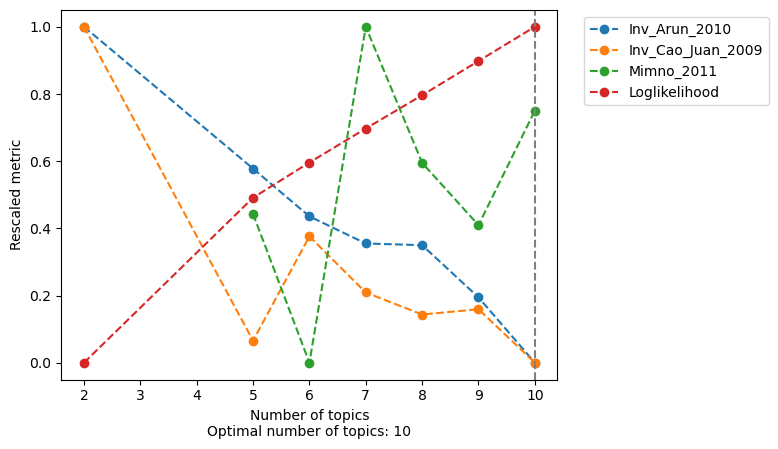

In [88]:
from pycisTopic.lda_models import *
model=evaluate_models(models,
                     select_model=10, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'model_selection_.pdf')

In [89]:
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

In [83]:
# # Save
# with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
#   pickle.dump(cistopic_obj, f)

## 7. Clustering and visualization

We can cluster the cells (or regions) using the leiden algorithm, and perform dimensionality reductiion with UMAP and TSNE. In these examples we will focus on the cells only. For these steps, the cell-topic contriibutions of the model will be used. In this tutorial we will not perform clustering as we will use the scRNA-seq labels, but you can take a look to the `find_clusters` function or the human cerebellum/melanoma tutorials.

In [72]:
# # Load cisTopic object
# import pickle
# infile = open(outDir + 'cisTopicObject.pkl', 'rb')
# cistopic_obj = pickle.load(infile)
# infile.close()

In [90]:
cistopic_obj.projections = {"cell": {}, "region": {}} #after subset

In [94]:
from pycisTopic.clust_vis import *
# run_umap(cistopic_obj,
#                  target  = 'cell', scale=False)
run_tsne(cistopic_obj,
                 target  = 'cell', scale=False)

2024-07-29 12:56:06,300 cisTopic     INFO     Running TSNE


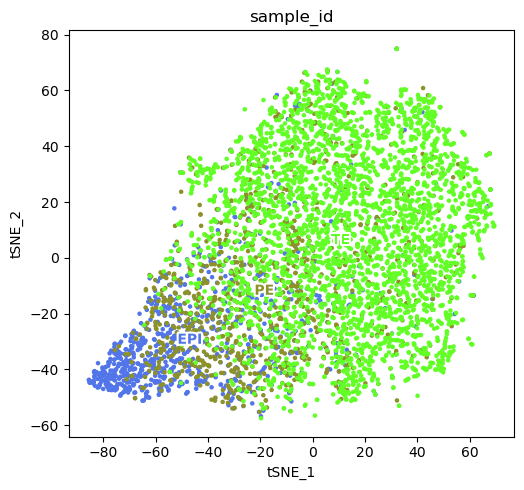

In [95]:
# os.mkdir(outDir + 'visualization/')
plot_metadata(cistopic_obj,
                 reduction_name='tSNE',
                 variables=['sample_id'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,5),
                 save= outDir + 'visualization/dimensionality_reduction.pdf')
# 40 1500

In [ ]:

plot_topic(cistopic_obj,
            reduction_name = 'UMAP',
            target = 'cell',
            num_columns=5,
            save= outDir + 'visualization/dimensionality_reduction_topics.pdf')


In [96]:
# Save
with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

Taking a closer look to the cell-topic distribution, we observe cell-type specific and cell-type+sample specific topics. For example, topic 1 is shared between all oligodendrocytes, while topics 20 and 59 are sample dependant oligodendrocyte topics.

pycisTopic allows to use harmony of cell-topic distributions to correct this kind of batch effects. Let's give it a try:

Indeed, now we observe that cells cluster by cell type.

We can also color this representation by topic contribution. Note that we do not remove the sample-specific topics, as these can still be explored to check if the batch has a biological effect.

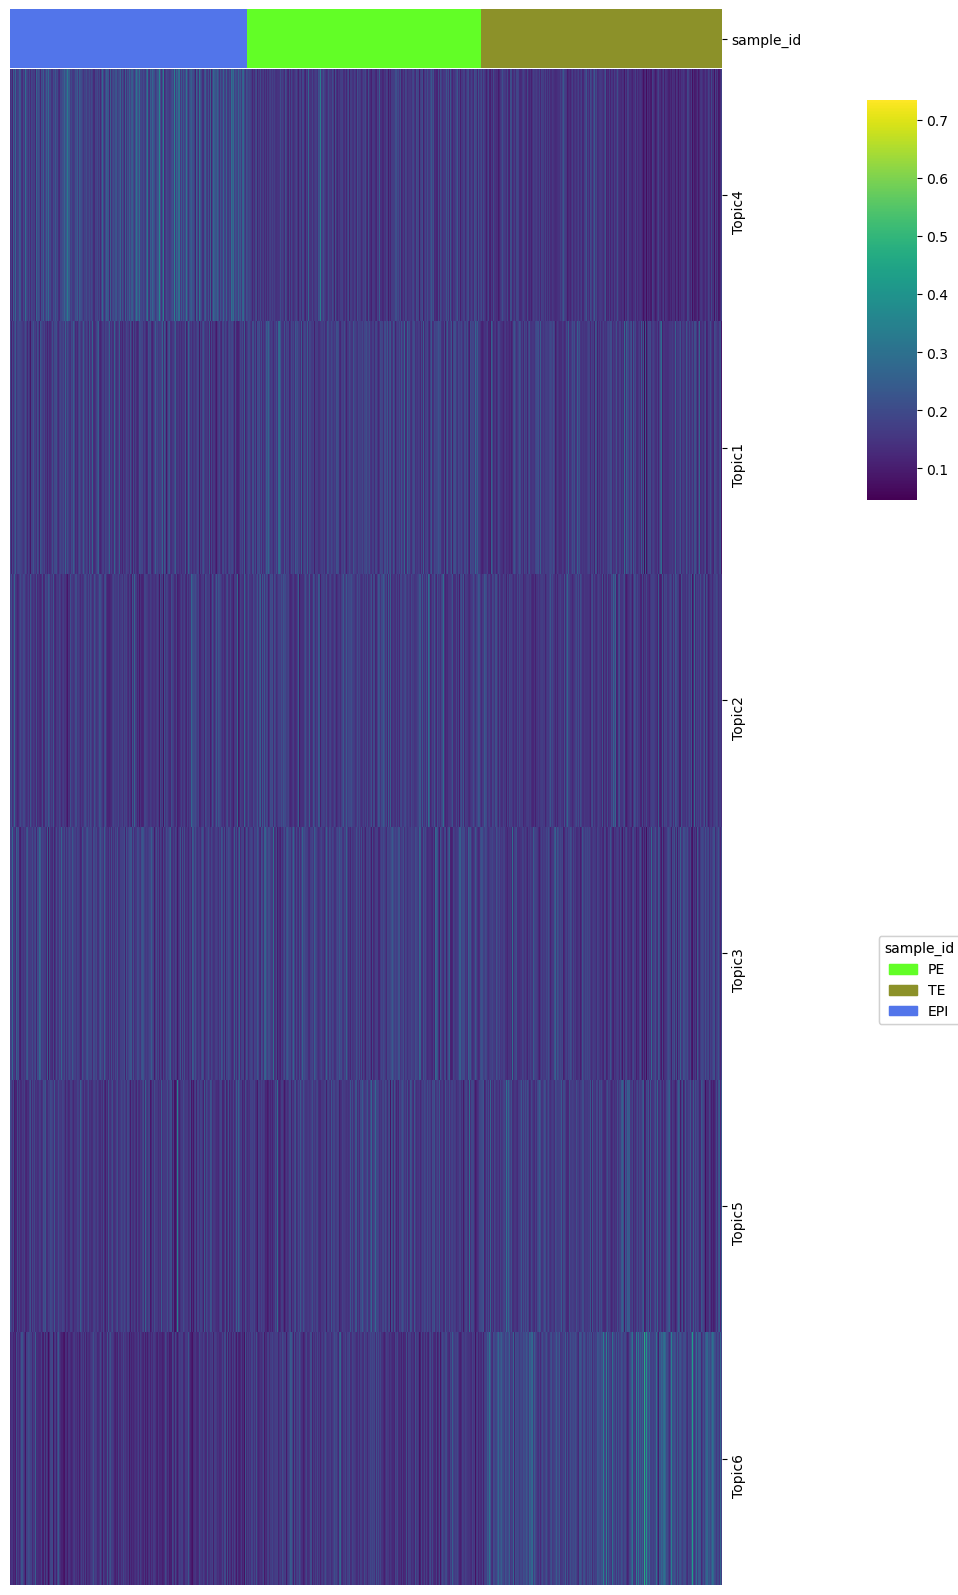

In [321]:
from pycisTopic.clust_vis import *
cell_topic_heatmap(cistopic_obj,
                     variables = ['sample_id'],
                     scale = False,
                     legend_loc_x = 1.05,
                     legend_loc_y = -1.2,
                     legend_dist_y = -1,
                     figsize=(10,20),
                     save = outDir + 'visualization/heatmap_topic_contr.pdf')

In [322]:
# Save
with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)